In [1]:
from onai.ml.peers.experiment.evaluate_consensus import (
    extract_task_analyst_id, 
    handle_file,
    map_decision_to_rank,
    POS_NEG_COL_NAME,
    REASON_1_COL_NAME,
    REL_POS_COL_NAME
)

from onai.ml.peers.experiment.modeling.base import RankNet

from onai.ml.peers.feature_extractor import _LAST_REVENUE_WINDOWS

from collections import defaultdict
import numpy as np
import json
import os
import pandas as pd
import smart_open

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn import preprocessing
from sklearn.model_selection import KFold

torch.set_num_threads(4)

## Train the model

Main reference source is:

Burges, Chris, et al. "Learning to rank using gradient descent." Proceedings of the 22nd international conference on Machine learning. 2005.

In [2]:
model_path = "s3://oaknorth-ml-dev-eu-west-1/iat/data/peers/dfs_bert_r4"

with smart_open.open(f"{model_path}/train_df.csv", 'r') as f:
    X_df = pd.read_csv(f)
# with smart_open.open(f"{model_path}/val_df.csv", 'r') as f:
#     X_df = pd.concat([X_df, pd.read_csv(f)])

In [3]:
from onai.ml.peers.experiment.training.bert_trainer import _COLS, create_pairwise_set

cols= _COLS + ["bert_embedding_sim"]

In [4]:
print (len(cols))

41


In [5]:
from onai.ml.peers.metric import average_precision, ndcg_df

In [6]:
def train_net(X, Y, batch_size=16384, epochs=20000, lbd=1e-3, alpha=1e-3, lr=0.01):
    torch.manual_seed(42)
    np.random.seed(42)

    net = RankNet(cols)

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            optimizer.zero_grad()
            X_minibatch = X[i:i+batch_size]
            Y_minibatch = Y[i:i+batch_size]

            output = net(X_minibatch)
            loss = criterion(output, Y_minibatch)
            
            reg_loss_l1 = 0
            reg_loss_l2 = 0
            for param in net.parameters():
                reg_loss_l1 += param.norm(1)
                reg_loss_l2 += param.norm(2) ** 2
            
            loss += lbd * reg_loss_l1 + alpha * reg_loss_l2
            loss.backward()
            optimizer.step()

        if epoch % 1000 == 0:
            output = net(X)
            loss = criterion(output, Y)
            print(loss)
        
    return net

In [7]:
def cv_score(X, n_splits=5, lbd=0.0, alpha=0.0, lr=1e-3):
    task_ids = np.array(list(set(X["task_id"])))
    kf = KFold(n_splits=n_splits, random_state=42)
    map_sum = 0
    
    for i,(train_index, val_index) in enumerate(kf.split(task_ids)):
        train_ids = task_ids[train_index]
        val_ids = task_ids[val_index]
        print(f"----- Fold {i} -----")
        
        X_train, Y_train, _ = create_pairwise_set(X[X["task_id"].isin(train_ids)], cols)
        print (X_train.shape)
        net = train_net(X_train, Y_train, epochs=4000, lbd=lbd, alpha=alpha, lr=lr)
        
        X_val = X[X["task_id"].isin(train_ids)].copy()
        
        val_input = torch.from_numpy(X_val[cols].to_numpy()).float()
        X_val["predicted_f"] = net.predict(val_input).detach().numpy()
        map_val = X_val.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="predicted_f")
        print (f"MAP on training set {map_val.mean()}")
        
        X_val = X[X["task_id"].isin(val_ids)].copy()
        val_input = torch.from_numpy(X_val[cols].to_numpy()).float()
        X_val["predicted_f"] = net.predict(val_input).detach().numpy()
        
        map_val = X_val.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="predicted_f")
        map_sum += map_val.mean()

        print(f"MAP on validation set {map_val.mean()}")
        print("-------")
    
    return map_sum/n_splits

In [13]:
#cv_score(X_df)

In [14]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [19]:
def f(x):
    x = np.atleast_2d(np.exp(x))
    lbd = x[0,0]
    alpha= x[0,1]
    print(f"Training with lambda={lbd} and alpha={alpha}")
    return cv_score(X_df, lbd=lbd, alpha=alpha)

domain = [
    {"name":"lbd", "type":"continuous", "domain": (-12., 4.)},
    {"name":"alpha", "type":"continuous", "domain": (-12., 0)}
]

opt = BayesianOptimization(f=f,       
                           domain=domain,
                           maximize=True,
                           normalize_Y=True,
                           )

Training with lambda=8.540866502933734e-06 and alpha=5.5498981886985045e-05
----- Fold 0 -----
Training with lambda=33.73573409887703 and alpha=0.00023661100734572813
----- Fold 0 -----
Training with lambda=3.7399874387834435 and alpha=0.0033362000795055594
----- Fold 0 -----
Training with lambda=0.00018363247264704296 and alpha=0.001095373611387036
----- Fold 0 -----
Training with lambda=0.0001126978150197447 and alpha=0.0002024028949332221
----- Fold 0 -----
Error in parallel computation. Fall back to single process!
Training with lambda=8.540866502933734e-06 and alpha=5.5498981886985045e-05
----- Fold 0 -----
torch.Size([12908, 82])
tensor(0.6700, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5885, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5757, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5686, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
MAP on training set 0.6612622665349295
MAP on validation set 0.5820383962915312
-------
----- Fold 1 ---

tensor(0.6053, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5981, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5960, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
MAP on training set 0.6194787995752525
MAP on validation set 0.7507285679122155
-------
Training with lambda=0.0001126978150197447 and alpha=0.0002024028949332221
----- Fold 0 -----
torch.Size([12908, 82])
tensor(0.6700, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5895, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5780, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5719, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
MAP on training set 0.6572942143979215
MAP on validation set 0.5874807603816958
-------
----- Fold 1 -----
torch.Size([13335, 82])
tensor(0.6712, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5998, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5926, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5895, grad_fn=<BinaryCro

In [20]:
opt.run_optimization(max_iter=15)
opt.plot_convergence()

Training with lambda=0.00010266796942402276 and alpha=6.14421235332821e-06
----- Fold 0 -----
Error in parallel computation. Fall back to single process!
Training with lambda=0.00010266796942402276 and alpha=6.14421235332821e-06
----- Fold 0 -----
torch.Size([12908, 82])
tensor(0.6700, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5757, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5683, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
MAP on training set 0.6619950078568829
MAP on validation set 0.5806046466654814
-------
----- Fold 1 -----


KeyboardInterrupt: 

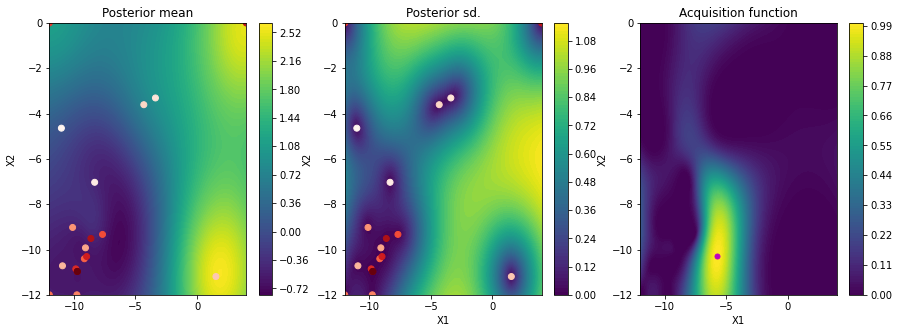

In [12]:
opt.plot_acquisition()

In [13]:
lbd_best = opt.X[np.argmin(opt.Y)]
lbd_best = np.exp(lbd_best)

In [14]:
lbd_best

array([1.15740542e-04, 4.88539344e-05])

In [8]:
X_train, Y_train, _ = create_pairwise_set(X_df, cols)
# net = train_net(X_train, Y_train, epochs=20000, lbd=lbd_best[0], alpha=lbd_best[1], lr=1e-3)
net = train_net(X_train, Y_train, epochs=20000, lbd=1.15740542e-04, alpha=4.88539344e-05, lr=1e-3)

tensor(0.6722, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6060, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6041, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6065, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6086, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6100, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6109, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6116, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6120, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6123, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6125, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6127, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6128, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6129, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6130, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6130, grad_fn=<BinaryCrossEntropyWithLogitsBac

In [9]:
# net = train_net(X_train, Y_train, epochs=20000, lbd=1.0e-4, alpha=1.0e-5, lr=1e-3)

In [10]:
X_train.shape

torch.Size([16749, 82])

In [11]:
dim = X_train.shape[1] // 2

scales = np.std((X_train[:, :dim] - X_train[:, dim:]).detach().numpy(), axis=0)

In [12]:
weights = net.scorer.fc.weight.detach().numpy()[0]
for weight, feature in sorted(zip(weights, cols), key=lambda x: -abs(x[0])):
    print(feature, weight)

bert_embedding_sim 7.152653
weighted_intersection 6.408249
weighted_intersection_negative_sample 3.511992
last_ebitda_diff_1.40 3.4468834
last_ebit_diff_1.60 2.6926236
last_ebit_diff_2.00 -2.6059036
last_revenue_diff_1.60 2.5105805
last_revenue_diff_1.40 -2.3769057
weighted_intersection_negative_sample_tail_end 2.1910882
last_ebitda_diff_1.20 -1.9779328
last_ebitda_diff_0.60 1.4066777
is_subsidiary -1.4019039
last_ebitda_diff_0.20 -1.3042473
last_revenue_diff_1.20 1.1374536
no_last_revenue_diff 1.120004
last_ebit_diff_0.80 -0.9037796
last_ebit_diff_1.80 -0.7854421
last_ebit_diff_1.40 -0.7663686
last_ebitda_diff_2.00 -0.6672857
weighted_symmetric_diff 0.6573975
country_overlap -0.43900365
last_revenue_diff_0.40 0.43397385
last_ebitda_diff_1.00 0.4218008
last_ebitda_diff_0.40 -0.38494235
no_last_ebit_diff 0.37695116
last_revenue_diff_1.00 0.3156629
last_revenue_diff_1.80 -0.2867537
last_revenue_diff_0.60 0.14943916
last_revenue_diff_0.80 0.107149646
peer_diff 0.036268342
last_ebit_diff_0

In [13]:
with smart_open.open(f"{model_path}/val_df.csv", 'r') as f:
    X_df_test = pd.read_csv(f)

In [14]:
X_test, Y_test, _ = create_pairwise_set(X_df_test, cols)

In [15]:
criterion = nn.BCEWithLogitsLoss()

output_test = net(X_test)
loss = criterion(output_test, Y_test)

In [16]:
loss

tensor(0.5718, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [17]:
test_tasks = set(X_df_test["task_id"])

In [18]:
train_input = torch.from_numpy(X_df[cols].to_numpy()).float()
X_df["predicted_f"] = net.predict(train_input).detach().numpy()

In [19]:
#X_df.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="es_rank")

In [20]:
#X_df.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="predicted_f")

In [21]:
X_df.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="es_rank", reverse=True).mean()

0.5678076444070481

In [22]:
X_df.groupby(["task_id", "analyst_id"]).apply(ndcg_df, score_column="es_rank", reverse=True).mean()

0.634795124773135

In [23]:
X_df.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="predicted_f", reverse=False).mean()

0.6238236031819852

In [24]:
X_df.groupby(["task_id", "analyst_id"]).apply(ndcg_df, score_column="predicted_f", reverse=False).mean()

0.6831112075548348

In [25]:
test_input = torch.from_numpy(X_df_test[cols].to_numpy()).float()
X_df_test["predicted_f"] = net.predict(test_input).detach().numpy()

In [26]:
def visualise_task(investigate_df, task):
    task_df = investigate_df[investigate_df["task_id"] == task]
    task_df_original = (task_df[["business_description", "relevance_score", "es_score"]]
                        .sort_values("es_score", ascending=[0])
                       ).reset_index()[["business_description", "relevance_score"]]
    task_df_ltr = (task_df[["business_description", "relevance_score", "predicted_f"]]
                        .sort_values("predicted_f", ascending=[0])
                       ).reset_index()[["business_description", "relevance_score"]]
    return pd.concat([task_df_original, task_df_ltr], axis=1)

In [27]:
#visualise_task(X_df, 1)

In [28]:
#X_df_test.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="es_rank")

In [29]:
#X_df_test.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="predicted_f")

In [30]:
#visualise_task(X_df_test, 55)

In [27]:
X_df_test.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="es_rank", reverse=True).mean()

0.5043495393067898

In [28]:
X_df_test.groupby(["task_id", "analyst_id"]).apply(ndcg_df, score_column="es_rank", reverse=True).mean()

0.6101449302118355

In [29]:
X_df_test.groupby(["task_id", "analyst_id"]).apply(average_precision, score_column="predicted_f").mean()

0.6913291872569345

In [30]:
X_df_test.groupby(["task_id", "analyst_id"]).apply(ndcg_df, score_column="predicted_f").mean()

0.7591771845898212

In [42]:
X_df_test

,bert_embedding_sim_hidden_state,bert_embedding_sim,bert_embedding_1st_sim,bert_embedding_pretrained,base_token_ids,peer_token_ids,last_revenue_diff_0.20,last_revenue_diff_0.40,last_revenue_diff_0.60,last_revenue_diff_0.80,...,Positive/Negative?,Relative Position,Reason 1 why it is negative,analyst_id,peer_entity_id,is_duplicate,relevance_score,task_id,es_rank,predicted_f
0,0.742310,0.930672,0.894936,0.759717,"[25649, 1084, 99, 2103, 7479, 18, 19, 14, 522,...","[17988, 18, 14912, 17, 12213, 15, 16389, 19, 1...",1.0,1.0,1.0,1.0,...,Negative,NaN,Same sector but business mismatch,c37b3d02-75cf-11ea-8fbc-060a6707e756_0,5d5d2fe2-8419-5e4d-8a3e-2e3928230ae2,False,0,64,0,7.382223
1,0.742310,0.930672,0.894936,0.759717,"[25649, 1084, 99, 2103, 7479, 18, 19, 14, 522,...","[17988, 18, 14912, 17, 12213, 15, 16389, 19, 1...",1.0,1.0,1.0,1.0,...,Negative,NaN,Same sector but business mismatch,d763f81a-72a3-11ea-96fb-0242ac110002_0,5d5d2fe2-8419-5e4d-8a3e-2e3928230ae2,False,0,64,0,7.382223
2,0.738876,0.951760,0.902177,0.751561,"[25649, 1084, 99, 2103, 7479, 18, 19, 14, 522,...","[17988, 18, 8199, 14912, 17, 12213, 13, 5, 217...",1.0,1.0,1.0,1.0,...,Negative,NaN,Same sector but business mismatch,c37b3d02-75cf-11ea-8fbc-060a6707e756_0,a6374166-0cad-50a7-beaa-74a42f776cbb,False,0,64,1,7.760122
3,0.738876,0.951760,0.902177,0.751561,"[25649, 1084, 99, 2103, 7479, 18, 19, 14, 522,...","[17988, 18, 8199, 14912, 17, 12213, 13, 5, 217...",1.0,1.0,1.0,1.0,...,Negative,NaN,Same sector but business mismatch,d763f81a-72a3-11ea-96fb-0242ac110002_0,a6374166-0cad-50a7-beaa-74a42f776cbb,False,0,64,1,7.760122
4,0.837984,0.928925,0.914333,0.872752,"[25649, 1084, 99, 2103, 7479, 18, 19, 14, 522,...","[8332, 18, 14912, 17, 3754, 12213, 15, 16389, ...",0.0,1.0,1.0,1.0,...,Positive,Least relevant,NaN,c37b3d02-75cf-11ea-8fbc-060a6707e756_0,8bcb49b5-9b4c-5517-b215-920f12fd87da,False,1,64,2,6.587843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.411339,0.959672,0.903056,0.386399,"[993, 6686, 15, 3016, 9, 18339, 15, 14751, 18,...","[28, 16, 409, 852, 15, 973, 15, 11140, 214, 50...",0.0,0.0,0.0,0.0,...,Negative,NaN,Same sector but business mismatch,1,NaN,False,0,61,14,4.510900
751,0.277903,0.964319,0.929185,0.136303,"[993, 6686, 15, 3016, 9, 18339, 15, 14751, 18,...","[3108, 8, 5011, 18, 15, 3016, 9, 15, 845, 508,...",0.0,0.0,0.0,0.0,...,Negative,NaN,Same sector but business mismatch,1,NaN,False,0,61,15,4.258395
752,0.211986,0.964151,0.923674,0.054880,"[993, 6686, 15, 3016, 9, 18339, 15, 14751, 18,...","[28611, 22, 18, 14699, 2837, 15, 3016, 9, 258,...",0.0,0.0,0.0,0.0,...,Negative,NaN,Same sector but business mismatch,1,NaN,False,0,61,16,2.640185
753,0.269601,0.968306,0.925239,0.109365,"[993, 6686, 15, 3016, 9, 18339, 15, 14751, 18,...","[28403, 1278, 3174, 1341, 15, 3016, 9, 14751, ...",0.0,0.0,0.0,0.0,...,Negative,NaN,Same sector but business mismatch,1,NaN,False,0,61,17,2.997876


In [32]:
def error_analysis(X, ranking_column="es_rank", reverse=True):
    joined_df = X.merge(X, on = [
        "task_id","analyst_id"
    ])
    
    ranking_column_mask = (joined_df[ranking_column+"_x"] < joined_df[ranking_column+"_y"]) \
                          if reverse else \
                          (joined_df[ranking_column+"_x"] > joined_df[ranking_column+"_y"])
        
    joined_df = joined_df[(joined_df["relevance_score_x"] < joined_df["relevance_score_y"]) &
                          ranking_column_mask &
                          (joined_df["relevance_score_y"] >= 1) &
                          (joined_df["relevance_score_x"] == 0)
                         ]
    
    joined_df = joined_df[[REASON_1_COL_NAME+"_x", "peer_name_x"]]
    
    return joined_df.groupby(REASON_1_COL_NAME+"_x").count()

In [36]:
def error_analysis_sp(X, ranking_column="es_rank"):
    joined_df = X.merge(X, on = [
        "task_id", "analyst_id"
    ])
    
    
    joined_df = joined_df[(joined_df["relevance_score_x"] < joined_df["relevance_score_y"]) &
                          (joined_df[ranking_column+"_x"] > joined_df[ranking_column+"_y"]) &
                          (joined_df["relevance_score_y"] >= 1) &
                          (joined_df["relevance_score_x"] == 0) &
                          (joined_df[REASON_1_COL_NAME+"_x"] == "Revenue range mismatch")
                         ]
    
    joined_df = joined_df[["peer_name_x", "peer_name_y"]]
    
    return joined_df

In [37]:
error_analysis(X_df, reverse=True)

,peer_name_x
Reason 1 why it is negative _x,
Geography mismatch,146
Other,5
Others,177
Revenue range mismatch,878
Same sector but business mismatch,2487
Sector mismatch,621
Short Business Description,7
Short business description,1536
Subsidiary of same parent,393


In [38]:
error_analysis(X_df, "predicted_f", False)

,peer_name_x
Reason 1 why it is negative _x,
Geography mismatch,110
Other,1
Others,92
Revenue range mismatch,556
Same sector but business mismatch,2074
Sector mismatch,494
Short Business Description,1
Short business description,415
Subsidiary of same parent,223


In [47]:
pd.set_option("display.max_rows", None)
error_analysis_sp(X_df, "predicted_f")

,peer_name_x,peer_name_y
8064,Brembo S.p.A.,Superior Industries Europe AG
8072,Brembo S.p.A.,Cesam
8081,Brembo S.p.A.,Corima S.A.
8087,Brembo S.p.A.,Fritz Berger GmbH
8091,Brembo S.p.A.,Wheelworld GmbH
8107,Brembo S.p.A.,"Oleohidráulica Ferruz, S.A."
8114,Brembo S.p.A.,MOMO Srl
8116,Brembo S.p.A.,Trelleborg Wheel Systems France SAS
20483,Hammerer Aluminium Industries GmbH,Impreglon Surface Engineering GmbH & Co. KG
24076,Yamaha Corporation,Blaby Road Realisations Ltd


In [43]:
output_path = "s3://oaknorth-ml-dev-eu-west-1/iat/data/peers/model/r4_linear"

#with smart_open.open(f"{output_path}/torch_net.pkl", 'wb') as f:
#   torch.save(net, f)



In [44]:
# save the last layer parameters in a json file 

weights = net.scorer.fc.weight.detach().numpy()[0]
weight_by_col_name = {feature: float(weight) for weight, feature in zip(weights, cols)}


with smart_open.open(f"{output_path}/last_layer_parm.json", 'w') as fout:
    json.dump(weight_by_col_name, fout)
    

In [33]:
error_analysis(X_df_test, ranking_column="predicted_f", reverse=False)

,peer_name_x
Reason 1 why it is negative _x,
Geography mismatch,12
Others,276
Revenue range mismatch,599
Same sector but business mismatch,336
Sector mismatch,139
Short business description,60
Subsidiary of same parent,5


In [34]:
error_analysis(X_df_test)

,peer_name_x
Reason 1 why it is negative _x,
Geography mismatch,14
Others,320
Revenue range mismatch,855
Same sector but business mismatch,489
Sector mismatch,122
Short business description,149
Subsidiary of same parent,10
